### Нарушение согласования

Начнем с поиска ошибки согласования прилагательных

3 типа:
* новЫЙ
* хорошИЙ
* большОЙ

### 1. Построим бандл, сбалансированный по длине предложения и по корпусу.

In [3]:
from tg.grammar_ru.common import Loc
from tg.grammar_ru.corpus import CorpusReader, CorpusBuilder, BucketCorpusBalancer
from tg.grammar_ru.corpus.corpus_reader import read_data
import os
from pathlib import Path
from dotenv import load_dotenv
from tg.grammar_ru.components.yandex_storage.s3_yandex_helpers import S3YandexHandler

from yo_fluq_ds import Queryable, Query, fluq

from typing import List, Union

import math
import pandas as pd
pd.set_option('display.max_rows', 500)


In [4]:
NEW = {
    "ая",
    "ого",
    "ое",
    "ой",
    # "ом",
    # "ому",
    "ую",
    "ые",
    "ый",
    "ым",
    "ыми",
    "ых"
}
# NOTE выкинули 'ою'

GOOD = {
    "ая",
    "его",
    "ее",
    "ей",
    "ем",
    "ему",
    "ие",
    "ий",
    "им",
    "ими",
    "их",
    "ую",
    "яя",
    "юю",
    "ого",
    "ое",
    "ой",
    "ому",
    "ом",
}  # легкий

BIG = {
    "ая",
    "ие",
    "им",
    "ими",
    "их",
    "ого",
    "ое",
    "ой",
    # "ом",
    # "ому",
    "ую",
    "ые",
    "ым",
    "ыми",
    "ых",
}  # золотой
# NOTE выкинули 'ою'

NEW_list = sorted(list(NEW))
GOOD_list = sorted(list(GOOD))
BIG_list = sorted(list(BIG))

In [5]:
index = pd.read_parquet(Loc.data_cache_path / 'bundles/agreement/adj_mid50/index.parquet')

In [6]:
from tg.common.ml.batched_training import IndexedDataBundle
from tg.common import DataBundle

db = DataBundle.load(Loc.data_cache_path/'bundles/agreement/adj_mid50')
idb = IndexedDataBundle(index, db)
idb.bundle

{'index': {'shape': (9300, 5), 'index_name': 'sample_id'}, 'pymorphy': {'shape': (171808, 16), 'index_name': 'word_id'}, 'src': {'shape': (171808, 18), 'index_name': None}, 'snowball': {'shape': (171808, 4), 'index_name': 'word_id'}}

##### Отправка бандла

In [7]:
from tg.grammar_ru.components import PlainContextBuilder

context_builder = PlainContextBuilder(
    include_zero_offset=True,
    left_to_right_contexts_proportion=0.5
)

In [8]:
from tg.common.ml.batched_training import context as btc
from tg.grammar_ru.components import CoreExtractor

def create_assembly_point(context_length = 6):
    ap = btc.ContextualAssemblyPoint(
        name = 'features',
        context_builder = context_builder,
        extractor = CoreExtractor(join_column='another_word_id'),
        context_length=context_length
    )
    ap.reduction_type = ap.reduction_type.Dim3Folded
    return ap

In [9]:
ap = create_assembly_point(context_length=10)
ap.hidden_size = 50
ap.dim_3_network_factory.network_type = btc.Dim3NetworkType.LSTM
head_factory = ap.create_network_factory()
# head = head_factory(batch)

In [10]:
import torch


def _update_sizes_with_argument(argument_name, argument, sizes, modificator):
    if argument is None:
        return sizes
    elif isinstance(argument, torch.Tensor):
        return modificator(sizes, argument.shape[1])
    elif isinstance(argument, pd.DataFrame):
        return modificator(sizes, argument.shape[1])
    elif isinstance(argument, int):
        return modificator(sizes, argument)
    else:
        raise ValueError(
            f"Argument {argument_name} is supposed to be int, Tensor or none, but was `{argument}`")


class FullyConnectedNetwork(torch.nn.Module):
    def __init__(self,
                 sizes: List[int],
                 input: Union[None, torch.Tensor, int] = None,
                 output: Union[None, torch.Tensor, int] = None):
        super(FullyConnectedNetwork, self).__init__()
        sizes = _update_sizes_with_argument(
            'input', input, sizes, lambda s, v: [v] + s)
        sizes = _update_sizes_with_argument(
            'output', output, sizes, lambda s, v: s + [v])
        self.layers = torch.nn.ModuleList()
        for i in range(len(sizes) - 1):
            self.layers.append(torch.nn.Linear(sizes[i], sizes[i + 1]))
        
        
    def forward(self, input):
        X = input
        for layer in self.layers:
            X = layer(X)
            # X = torch.sigmoid(X)
        return X

In [11]:
import torch
from tg.common.ml.batched_training import factories as btf


class Network(torch.nn.Module):
    def __init__(self, head, hidden_size, batch):
        super(Network, self).__init__()
        self.head = head
        self.tail = FullyConnectedNetwork(
            sizes=[], input=hidden_size, output=batch.index_frame.label.nunique())

    def forward(self, batch):
        return self.tail(self.head(batch))


class NetworkFactory:
    def __init__(self, assembly_point):
        self.assembly_point = assembly_point

    def __call__(self, batch):
        head_factory = self.assembly_point.create_network_factory()
        head = head_factory(batch)
        return Network(head, self.assembly_point.hidden_size,  batch)


network_factory = NetworkFactory(ap)


In [12]:
from tg.common.ml import batched_training as bt
from sklearn.metrics import roc_auc_score, f1_score

class MulticlassMetrics(bt.Metric):
    def get_names(self):
        return ['roc_auc', 'f1_weighted']

    def measure(self, df, _):
        prefix = 'predicted_label_'
        target = df.label.tolist()
        probas = np.zeros(shape=[len(df), idb.index_frame.label.nunique()])
        for i, (_, row) in enumerate(df.iterrows()):
            for j in range(probas.shape[1]):
                probas[i][j] = row[f'{prefix}{j}']
    
        preds = np.argmax(probas, axis=1).tolist()
        result = []
        result.append(roc_auc_score(target, probas, multi_class='ovo'))
        result.append(f1_score(target, preds, average='weighted'))
        return result

In [125]:
from typing import *
from tg.common.ml import batched_training as bt
import pandas as pd
from tg.common.ml.batched_training.factories.conventions import Conventions
import torch
from yo_fluq_ds import Obj


class MulticlassPredictionInterpreter:
    def interpret(self, input, labels, output):
        result = input["index"].copy()
        output = torch.softmax(output, dim=1)
        for i, c in enumerate(labels.columns):
            result["true_" + c] = labels[c]
            result["predicted_" + c] = output[:, i].tolist()
        return result

In [107]:
from tg.common.ml.batched_training.factories import CtorAdapter, TorchModelHandler
from sklearn.metrics import roc_auc_score
import pandas as pd
import numpy as np
from tg.common.ml import batched_training as bt
from tg.common.ml import dft


def get_multilabel_extractor():
    label_extractor = (bt.PlainExtractor
                       .build(btf.Conventions.LabelFrame)
                       .index()
                       .apply(take_columns=['label'],
                              transformer=dft.DataFrameTransformerFactory.default_factory(max_values_per_category=46))
                       )
    return label_extractor


class TrainingTask(btf.TorchTrainingTask):
    def __init__(self):
        super(TrainingTask, self).__init__()
        self.metric_pool = bt.MetricPool().add(MulticlassMetrics())
        self.features_ap = create_assembly_point()
        # self.settings.mini_batch_size = None

    def initialize_task(self, idb):
        self.setup_batcher(
            idb, [ap.create_extractor(), get_multilabel_extractor()])
        self.setup_model(network_factory, ignore_consistancy_check=True)

    def setup_model(self, network_factory, ignore_consistancy_check=False):
        self.model_handler = TorchModelHandler(
            network_factory,
            self.optimizer_ctor,
            self.loss_ctor,
            ignore_consistancy_check,
        )
        self.model_handler.multiclass_prediction_interpreter = MulticlassPredictionInterpreter()
task = TrainingTask()
task.settings.epoch_count = 100
task.optimizer_ctor = CtorAdapter("torch.optim:Adam", ('params',), lr=3e-4)
task.loss_ctor = CtorAdapter("torch.nn:CrossEntropyLoss")
result = task.run(idb)

2023-12-27 01:44:47.568736 INFO: Training starts. Info: {}
2023-12-27 01:44:47.569385 INFO: Ensuring/loading bundle. Bundle before:
{'index': {'shape': (4954, 5), 'index_name': 'sample_id'}, 'pymorphy': {'shape': (171808, 16), 'index_name': 'word_id'}, 'src': {'shape': (171808, 18), 'index_name': None}, '@index_frame': {'shape': (4954, 5), 'index_name': 'sample_id'}}
2023-12-27 01:44:47.569646 INFO: Bundle loaded
{'index': {'shape': (4954, 5), 'index_name': 'sample_id', 'columns': ['word_id', 'sentence_id', 'declension_type', 'label', 'split'], 'index': [0, 1, 2, 3, 4, '...']}, 'pymorphy': {'shape': (171808, 16), 'index_name': 'word_id', 'columns': ['normal_form', 'alternatives', 'score', 'delta_score', 'POS', '...'], 'index': [0, 1, 2, 3, 4, '...']}, 'src': {'shape': (171808, 18), 'index_name': None, 'columns': ['word_id', 'sentence_id', 'word_index', 'paragraph_id', 'word_tail', '...'], 'index': [0, 1, 2, 3, 4, '...']}}
2023-12-27 01:44:47.569821 INFO: Index frame is set to index, sh

In [108]:
import joblib

joblib.dump(result['output']['model'], 'adjectives_decl_new_model.pkl')
joblib.dump(result['output']['batcher'], 'adjectives_decl_new_batcher.pkl')

['adjectives_decl_new_batcher.pkl']

In [109]:
model = joblib.load('adjectives_decl_new_model.pkl')
batcher = joblib.load('adjectives_decl_new_batcher.pkl')

In [110]:
task = TrainingTask()
task.model_handler = model
task.batcher = batcher 

In [111]:
pred_db = task.predict(idb)

2023-12-27 01:46:26.997033 INFO: Evaluating prediction: 0/1


In [112]:
pred_db.label.value_counts()

6    995
5    689
0    577
9    516
3    479
2    441
7    416
1    409
4    250
8    182
Name: label, dtype: int64

In [113]:
import numpy as np
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score, accuracy_score, balanced_accuracy_score

def score_db(db):
    prefix = 'predicted_label_'
    target = db.label.tolist()
    probas = np.zeros(shape=[len(db), idb.index_frame.label.nunique()])
    for i, (_, row) in enumerate(db.iterrows()):
        for j in range(probas.shape[1]):
            probas[i][j] = row[f'{prefix}{j}']
    
    preds = np.argmax(probas, axis=1).tolist()
    return precision_recall_fscore_support(target, preds, average='weighted')
    # return accuracy_score(target, preds)

In [114]:
score_db(pred_db[pred_db.split == 'train'])

(0.9936913246081818, 0.9936544563022787, 0.9936548352318334, None)

In [115]:
NEW_list

['ая', 'ого', 'ое', 'ой', 'ую', 'ые', 'ый', 'ым', 'ыми', 'ых']

In [116]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(db):
    prefix = 'predicted_label_'
    target = db.label.tolist()
    probas = np.zeros(shape=[len(db), idb.index_frame.label.nunique()])
    for i, (_, row) in enumerate(db.iterrows()):
        for j in range(probas.shape[1]):
            probas[i][j] = row[f'{prefix}{j}']

    preds = np.argmax(probas, axis=1).tolist()
    cm = confusion_matrix(target, preds, normalize='true').round(2)
    ConfusionMatrixDisplay(cm, display_labels=NEW_list).plot()

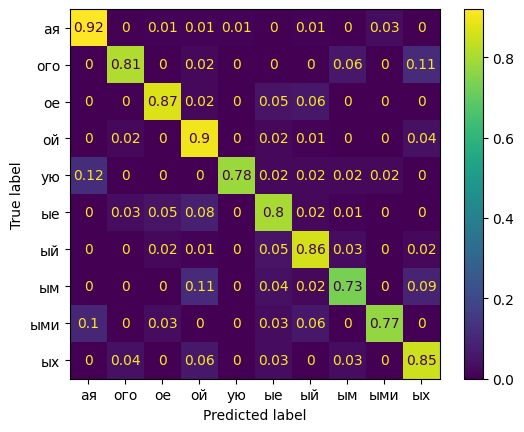

In [117]:
plot_confusion_matrix(pred_db[pred_db.split == 'test'])

In [118]:
import tg.projects.agreement.declension_extractor as de
import importlib

importlib.reload(de)

<module 'tg.projects.agreement.declension_extractor' from '/home/matvey/PycharmProjects/grammar_ru/tg/projects/agreement/declension_extractor.py'>

In [119]:
from tg.projects.agreement.declension_extractor import AdjAgreementIndexBuilder, AdjectivelessPyMorphyFeaturizer
from tg.grammar_ru import Separator

test_text = 'У нас новое улица, громадная дом и быстрые машина'
test_text_db = Separator.build_bundle(test_text, [AdjectivelessPyMorphyFeaturizer()])
test_text_db


{'src': {'shape': (10, 8), 'index_name': None}, 'pymorphy': {'shape': (10, 16), 'index_name': 'word_id'}}

In [120]:
index_df = AdjAgreementIndexBuilder().build_index(test_text_db, 0)
index_df

,word_id,sentence_id,declension_type
sample_id,,,
2,2,0,0
5,5,0,0
8,8,0,0


In [121]:
input_idb = IndexedDataBundle(
    index_frame=index_df,
    bundle=test_text_db
)
input_idb.bundle.src['label'] = 0
input_idb.index_frame['label'] = 0

In [122]:
pred_df = task.predict(input_idb)
pred_df

2023-12-27 01:46:27.773218 INFO: Evaluating prediction: 0/1


,word_id,sentence_id,declension_type,label,true_label_6,predicted_label_6,true_label_5,predicted_label_5,true_label_0,predicted_label_0,...,true_label_2,predicted_label_2,true_label_7,predicted_label_7,true_label_1,predicted_label_1,true_label_4,predicted_label_4,true_label_8,predicted_label_8
sample_id,,,,,,,,,,,,,,,,,,,,,
2,2,0,0,0,0.0,0.000012,0.0,0.036340,1.0,0.000239,...,0.0,0.001617,0.0,7.075955e-03,0.0,1.848655e-04,0.0,0.000008,0.0,0.000002
5,5,0,0,0,0.0,0.000185,0.0,0.000029,1.0,0.996190,...,0.0,0.000013,0.0,1.950989e-07,0.0,2.939482e-07,0.0,0.003492,0.0,0.000090
8,8,0,0,0,0.0,0.195001,0.0,0.001280,1.0,0.669162,...,0.0,0.000148,0.0,1.234464e-03,0.0,1.184716e-05,0.0,0.133110,0.0,0.000050


In [123]:
import numpy as np
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score, accuracy_score, balanced_accuracy_score

def condense_predictions(pred_df):
    prefix = 'predicted_label_'
    pred_columns = pred_df.columns[pred_df.columns.str.startswith(prefix)]
    pred_labels = pred_df[pred_columns].idxmax(axis=1)
    pred_labels = pred_labels.apply(lambda column_name: int(column_name.split('_')[-1]))
    condensed_df = pd.DataFrame(pred_labels, columns=['label'])
    aib = AdjAgreementIndexBuilder()
    condensed_df['ending'] = condensed_df.label.apply(lambda x: aib.get_ending_from_index(0, x))
    return condensed_df

In [124]:
condense_predictions(pred_df)

,label,ending
sample_id,,
2,3,ой
5,0,ая
8,0,ая


### Результат

##### Бандл

* Сбалансировали по длине и по корпусу. pub & books
* Построили фичи
* Отобрали прилагательные с помощью pymorphy & mystem
* Определили типы склонения и окончания


##### Сеть

* Собрали и запустили в ноутбуке

##### В процессе

* Доставка
